In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy import stats
import scipy.integrate as integrate

y = [1505.0, 1528, 1564, 1498, 1600, 1470]
m0 = np.mean(y)
sigma = np.sqrt(500)
n = len(y)

def fun(tau0):
    ll = stats.norm.logpdf
    integrand = lambda theta: n * ll(theta, m0, tau0) + sum(ll(y, theta, sigma))
    return -integrate.quad(integrand, -np.inf, np.inf)[0]

minimize(fun, 1)

   status: 2
  success: False
     njev: 42
     nfev: 126
 hess_inv: array([[1]])
      fun: nan
        x: array([ -2.89575666e+10])
  message: 'Desired error not necessarily achieved due to precision loss.'
      jac: array([ nan])

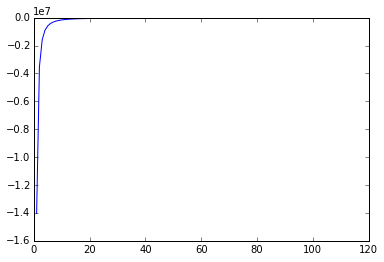

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

tau = np.arange(1, 102)
plt.plot(tau, [fun(t) for t in tau])
plt.show()